In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dummy-astronomy-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1396185%2F2326393%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T015339Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9dadce10f9e1f9ec6b49e5cd754161f8b07cf0cfdd94836712f0f0d1aecb8c5d4976b0dcc6eda55ea9763ac2838bd16c685a740600ffa5b0610ba1f5fcbde66ced1af96ba684cd9983f615d2c35fca774d542a0b4d3f3ace78ad97e95e0358823cf3d49dcff6c2d0a669b848c665999fd34f3f255b3667a144f2bc818d2ac94a76762f6a3db5cfa56a75b893c088b14dbbf57ac11d99664dde2b06f6189f81add6cf8bf4e006bf00a4f1a6b447c25e75bad37f394585679fc3265690414a1987ea86909084aa0c34b1b1e3b232822e5d2d85f73ed76ea5fe9c976645b740222832aa0613353b3b423132521953a9abd0d91943d45e9750cd9a3a464778f0636f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 8876151 bytes downloaded
Downloaded and uncompressed: dummy-astronomy-data
Data source import complete.


# Star and galaxy

In [ ]:

%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn import datasets

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten

from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

# Utils


In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

# Split the images

In [ ]:
train_data_dir = "../input/dummy-astronomy-data/Cutout Files"
image_size = (30, 30)

dataset = image_dataset_from_directory(
    train_data_dir,
    image_size=image_size,
)

Found 3986 files belonging to 2 classes.


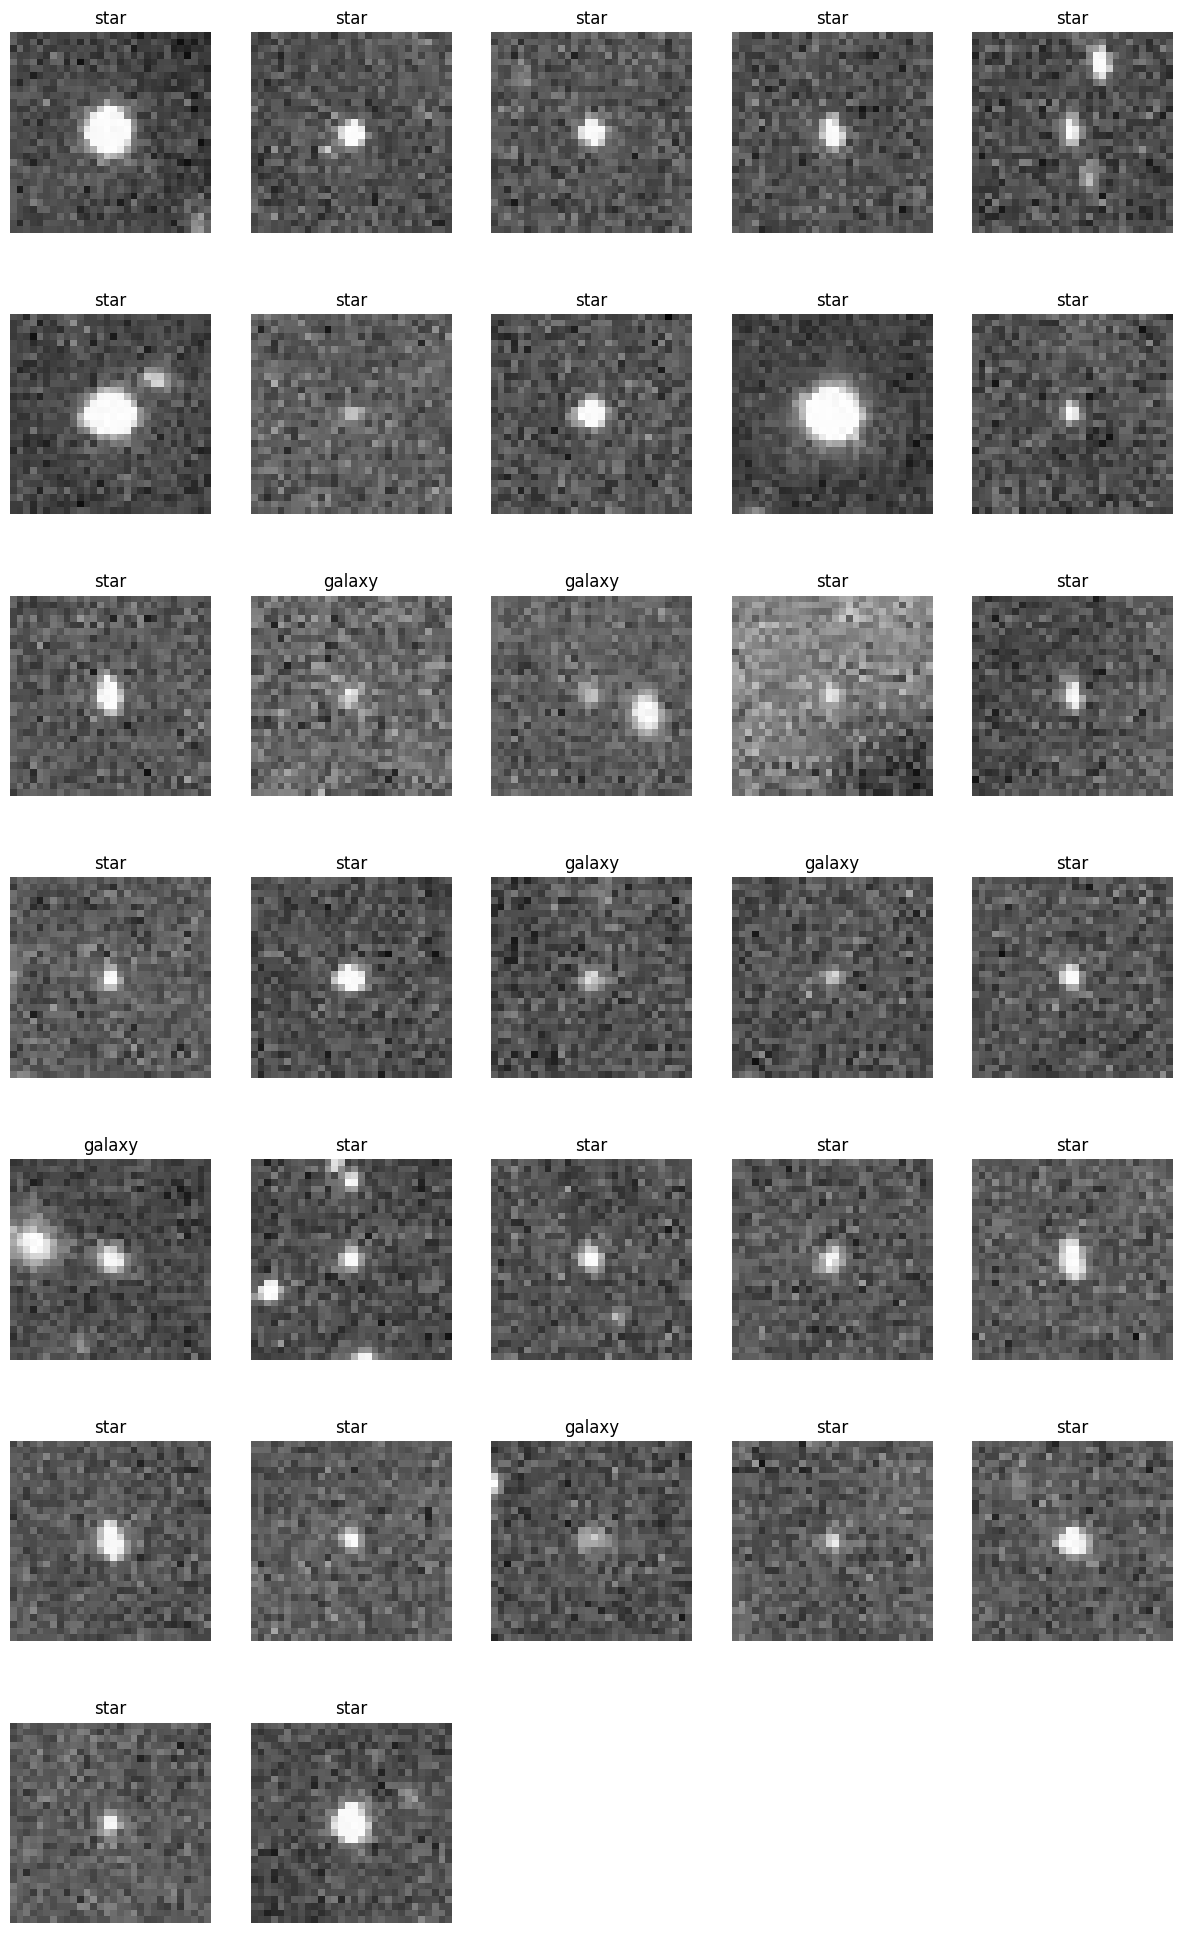

In [ ]:
plt.figure(figsize=(15, 25))
class_names = dataset.class_names
for images, labels in dataset.take(1):
    for i in range(32):
        plt.subplot(7, 5, i+1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Create the datasets

In [ ]:
train_data_dir = "../input/dummy-astronomy-data/Cutout Files"
image_size = (30, 30)

train_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    seed=1,
    subset="training",
    label_mode="categorical",
    image_size=image_size
)

test_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    seed=1,
    subset="validation",
    label_mode="categorical",
    image_size=image_size
)

Found 3986 files belonging to 2 classes.
Using 3189 files for training.
Found 3986 files belonging to 2 classes.
Using 797 files for validation.


# Model and training

In [ ]:
learning_rates = [.1, .2, .5]

lr_accuracies = []

best_learning_rate = 0

best_accuracy = 0

for i in learning_rates:
  model = Sequential()
  model.add(InputLayer(input_shape=(30, 30, 3)))
  model.add(Rescaling(scale=1./255))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(i))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(i))
  model.add(Conv2D(20, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(i))
  model.add(Flatten())
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  fitted_model = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10)

  print(f'Completed Learning rate: {i}')

  accuracy = fitted_model.history['val_accuracy'][-1]

  lr_accuracies.append(accuracy)

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_learning_rate = i

print(f'\nthis is the best learning rate: {best_learning_rate}')

Epoch 1/10
100/100 [==============================] - 12s 105ms/step - loss: 0.5089 - accuracy: 0.7667 - val_loss: 0.4636 - val_accuracy: 0.7516
Epoch 2/10
100/100 [==============================] - 18s 180ms/step - loss: 0.4364 - accuracy: 0.7764 - val_loss: 0.4143 - val_accuracy: 0.8030
Epoch 3/10
100/100 [==============================] - 16s 163ms/step - loss: 0.4011 - accuracy: 0.8050 - val_loss: 0.3588 - val_accuracy: 0.8394
Epoch 4/10
100/100 [==============================] - 10s 104ms/step - loss: 0.3614 - accuracy: 0.8338 - val_loss: 0.3357 - val_accuracy: 0.8570
Epoch 5/10
100/100 [==============================] - 12s 115ms/step - loss: 0.3492 - accuracy: 0.8432 - val_loss: 0.3339 - val_accuracy: 0.8570
Epoch 6/10
100/100 [==============================] - 12s 125ms/step - loss: 0.3225 - accuracy: 0.8639 - val_loss: 0.3419 - val_accuracy: 0.8482
Epoch 7/10
100/100 [==============================] - 12s 117ms/step - loss: 0.3126 - accuracy: 0.8667 - val_loss: 0.3193 - val_ac

In [ ]:
epoch_num = [10, 20, 50]
best_accuracy = 0
best_epoch = 0
accuracy_history= []
train_accuracy = []

for i in epoch_num:

  # Model CNN
  model = Sequential()
  model.add(InputLayer(input_shape=(30, 30, 3)))
  model.add(Rescaling(scale=1./255))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(best_learning_rate))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(best_learning_rate))
  model.add(Conv2D(20, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(best_learning_rate))
  model.add(Flatten())
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  fitted_model = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=i)

  accuracy = fitted_model.history['val_accuracy'][-1]

  print(f'Completed epoch: {i}')

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_epoch = i

  accuracy_history.append(fitted_model.history['val_accuracy'])
  train_accuracy.append(fitted_model.history['accuracy'])


print(f'this is the best epoch number: {best_epoch}')

Epoch 1/10
100/100 [==============================] - 12s 106ms/step - loss: 0.5131 - accuracy: 0.7629 - val_loss: 0.4528 - val_accuracy: 0.7516
Epoch 2/10
100/100 [==============================] - 10s 104ms/step - loss: 0.4280 - accuracy: 0.7733 - val_loss: 0.4133 - val_accuracy: 0.7842
Epoch 3/10
100/100 [==============================] - 10s 98ms/step - loss: 0.3959 - accuracy: 0.8200 - val_loss: 0.3751 - val_accuracy: 0.8068
Epoch 4/10
100/100 [==============================] - 10s 94ms/step - loss: 0.3755 - accuracy: 0.8335 - val_loss: 0.3797 - val_accuracy: 0.7955
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.3530 - accuracy: 0.8448 - val_loss: 0.3472 - val_accuracy: 0.8444
Epoch 6/10
100/100 [==============================] - 10s 104ms/step - loss: 0.3304 - accuracy: 0.8567 - val_loss: 0.3250 - val_accuracy: 0.8482
Epoch 7/10
100/100 [==============================] - 10s 98ms/step - loss: 0.3166 - accuracy: 0.8614 - val_loss: 0.3496 - val_accur

#Visualization

In [ ]:
accuracy_history_2 = []

for i in accuracy_history:
  accuracy_history_2.append(i[-1])

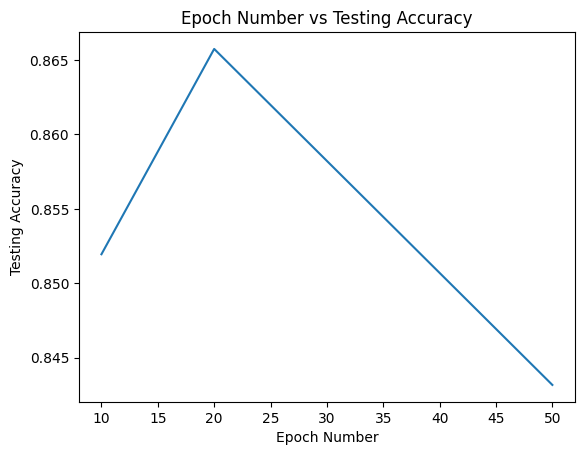

In [ ]:
plt.plot(epoch_num, accuracy_history_2)
plt.xlabel('Epoch Number')
plt.ylabel('Testing Accuracy')
plt.title("Epoch Number vs Testing Accuracy")
plt.show()

In [ ]:
lr_accuracies_2 = []

for i in lr_accuracies:
  lr_accuracies_2.append(lr_accuracies[-1])

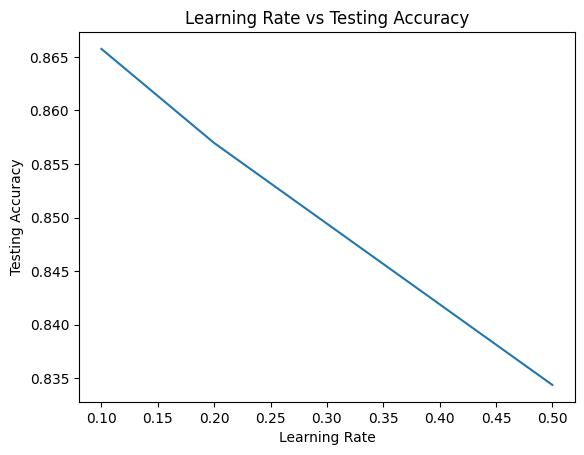

In [ ]:
plt.plot(learning_rates, lr_accuracies)
plt.xlabel('Learning Rate')
plt.ylabel('Testing Accuracy')
plt.title("Learning Rate vs Testing Accuracy")
plt.show()

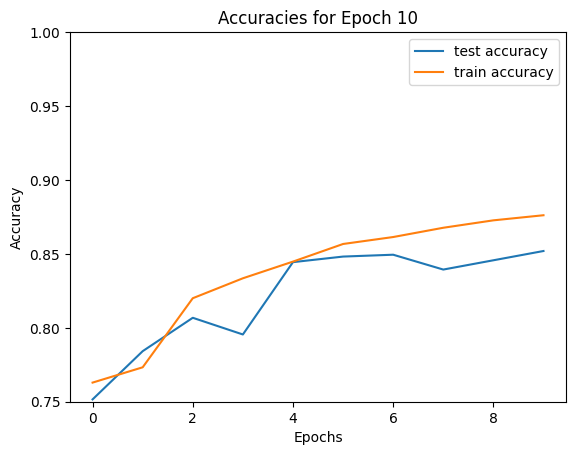

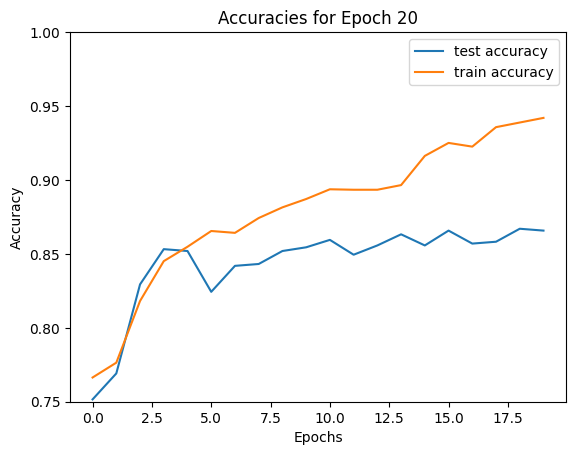

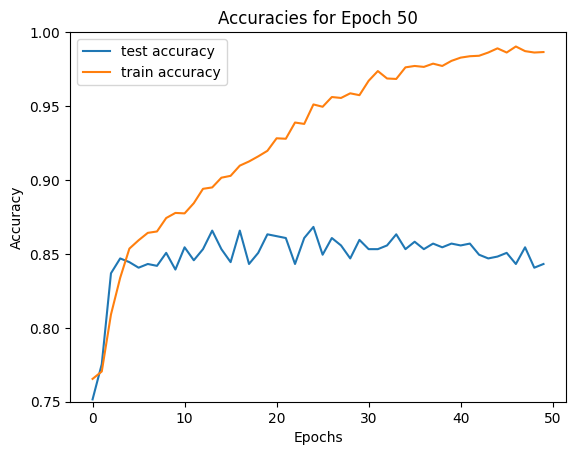

In [ ]:
for epoch in range(len(epoch_num)):
  test = accuracy_history[epoch]

  train = train_accuracy[epoch]

  plt.plot(range(len(test)), test, label = "test accuracy")
  plt.plot(range(len(train)), train, label = "train accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title(f'Accuracies for Epoch {epoch_num[epoch]}')
  plt.legend()
  plt.ylim(0.75, 1)
  plt.show( block=False )
  print()
